# Laboratoire 1 : Extraction de primitives
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | Ahmad Al-Taher - ALTA22109307                           |
|                       | Jean-Philippe Decoste - DECJ19059105                    |
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2018                                            |
| Groupe                | 2                                                       |
| Numéro du laboratoire | 01                                                      |
| Professeur            | Hervé Lombaert                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 10 oct 2018                                             |

In [26]:
import math

import cv2 as cv
import graphviz
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import face, imread, imshow
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from sklearn import preprocessing, tree
from sklearn.datasets import load_iris

In [18]:
class Image:
    def __init__(self, path, label, answer):
        """
             The only construct is to build an object type image that has all the elements required to make a decision weather it is
             a smooth or spiral galaxy
             
             Args:
                 self : refers to the class
                 path : Where the image is stored
                 label : The image name 
                 answer : The final answer (smooth or spiral). This is the answer from the data set. 
                          It is used to verify after making a decision. 
                          
              Returns:
                  An Image object with the image manipulations
         """
        self.Path = path
        self.Label = label
        self.Answer = answer
        self.Image = cv.imread(path)
        self.Pixels = np.array(self.Image)
        self.Width = self.Pixels.shape[0]
        self.Height = self.Pixels.shape[1]
        #we will always use the cropped image
        #default crop is 250
        #self.crop(self.Width) #no crop
        self.crop(200)

        #useful image manipulations
        self.manipulations()

        #default computations
        self.ComputeCircularity()
        self.computeBlackWhite()
        self.ComputeConvexity()
        self.ComputeBoundingRectangleToFillFactor()

        #plt.imshow(self.Image),plt.title('ORIGINAL')
        #plt.show()
        #cv.imshow('gray_image', self.remove_starlight()) 
        #plt.imshow(self.remove_starlight()),plt.title('GRAYSCALE')
        #plt.show()
        
    def manipulations(self):
        """
        This method is used to apply all the images manipulation on the image. Such as grayscale.
        Cropped image is the default image used 
        
        Args:
            self: refers to the class
        """
        #remove noise by blurring with a Gaussian filter
        self.CroppedPixels = cv.GaussianBlur(self.CroppedPixels,(3,3), 0)

        #convert to grayscale
        self.GrayScale = cv.cvtColor(self.CroppedPixels, cv.COLOR_BGR2GRAY)
        """remove background noise
        #the result is worst with laplacian
        #laplacian = cv.Laplacian(self._GrayScale, cv.CV_16S, 3)
        #laplacian = cv.convertScaleAbs(laplacian)
        #self._GrayScale = self._GrayScale - laplacian 
        """
        self.Threshold = threshold_otsu(self.GrayScale)
        self.Binary = self.GrayScale > self.Threshold
    
    def crop(self, dimentions):
        """
        This method is used to apply a crop to the image. Since the image is squared only on parameter is required 
        
        Args:
            dimentions: refers the final demention of the image. Such as the final image would have
                        dimentions*dimentions. Ex: dimentions=250 the image will be 250x250
        """
        # dimention is the width and Height to crop to. Since it is a square.
        upper_width = int(self.Width/2 + dimentions/2)
        lower_width = int(self.Width/2 - dimentions/2)
        upper_height = int(self.Height/2 + dimentions/2)
        lower_height = int(self.Height/2 - dimentions/2)
        #new array of the image
        self.CroppedPixels = self.Pixels[lower_width:upper_width, lower_height:upper_height]

    #All manipulations
    def remove_starlight(self):
        """ Removes the star light in images.

        Calclates the median in color and gray scale image to clean the image's background.

        Args:
             image_color: an OpenCV standard color image format.
             image_gray: an OpenCV standard gray scale image format.

        Returns:
            An image cleaned from star light.
        """
        t = np.max(np.median(self.Image[np.nonzero(cv.cvtColor(self.Pixels, cv.COLOR_BGR2GRAY))], axis=0))
        self.Image[self.Image < t] = t

        #return self.rescale(self.Image).astype("uint8")
        return self.rescale(self.Image)
        #return self.Image
    
    def rescale(self, image, min=20, max=255):
        """ Rescale the colors of an image.

        Utility method to rescale colors from an image. 

        Args: 
            image: an OpenCV standard image format.
            min: The minimum color value [0, 255] range.
            max: The maximum color value [0, 255] range.
        
        Returns:
            The image with rescaled colors.
        """
        image = image.astype('float')
        image -= image.min()
        image /= image.max()
        image = image * (max - min) + min

        return image
    
    def computeBlackWhite(self):
        """
        This method is used to compute the black and white ratio.
        The formula is blacks / whites
        
        Args:
            self: refers to the class
        """
        self.Black = 0
        self.White = 0
        self.BlackWhiteRatio = 0
        #compute the # of black and the # of whites
        for row in self.Binary:
            for pixel in row:
                if(pixel):
                    self.White += 1
                else:
                    self.Black += 1
        #compute the B/W ratio
        if self.Black > 0 and self.White > 0 :
            self.BlackWhiteRatio = self.Black / self.White
        else:
            self.BlackWhiteRatio = self.White / self.Black
        
    def ComputeCircularity(self):
        """
        This method is used to compute the circularity of the galaxy.
        The formula used is : 𝐶 = 4 ∗ 𝜋 ∗ 𝐴/𝑃2
        
        Args:
            self: refers to the class
         """
        #example from openCV documentation
        
        #thresh = cv.adaptiveThreshold(self.GrayScale, 100, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 501, 0)
        ret, thresh = cv.threshold(self.GrayScale, self.Threshold, 127, 0)
        img, contours, hierarchy = cv.findContours(thresh, 1 ,2)
        self.cnt = contours[0]
        #cv.imshow('img', img)
        
        self.area = cv.contourArea(self.cnt)
        self.perimeter = cv.arcLength(self.cnt,True)
        #circularity
        self.C = 0
        if self.area > 0 and self.perimeter > 0 :
            self.FormFactor = self.area/ math.pow(self.perimeter,2)
            self.C = 4 * math.pi * self.FormFactor 
    
    def ComputeConvexity(self):
        """
        This method is used to compute the convexity of the galaxy.
        The formula used is : 𝐶 = P / (2W + 2H)
        where P is the perimeter
        W is the width of the bounding rectangle
        H is the height of the bounding rectangle
        
        Args:
            self: refers to the class
         """
        x,y,w,h = cv.boundingRect(self.cnt)
        self.Convexity = self.perimeter / (2*w+2*h)

    def ComputeBoundingRectangleToFillFactor(self):
        """
        This method is used to compute the bounding rectangle to fill factor.
        The formula used is : B = A / (W*H)
        Where is A is the area of the shape
        W*H is the area of the bounding rectangle
        Args:
            self: refers to the class
         """
        x, y, w, h = cv.boundingRect(self.cnt)
        self.B = self.area / (w*h)
                

In [39]:
def loadAllImages(dataPath, imageFolderPath):
    """
    This method is used to al the images from the data set.
    
    Args:
        dataPath: the dataset file path
        imageFolderPath: the image dataset folder path
    """
    dataFile = open(dataPath, 'r') # option r veut dire read
    
    #index is used to load a define number of images.
    index = 1
    #Skip header
    next(dataFile)
    
    for line in dataFile:
        texts = line.split(",")
        imageName = texts[0]
        shape = str(texts[1])
        imagePath = imageFolderPath +"\\"+str(imageName)+'.jpg'
        
        if index % 3 != 2:
            trainDataSet.append(Image(imagePath,imageName,shape))
            index += 1
        else:
            testDataSet.append(Image(imagePath,imageName,shape))
            index += 1

    dataFile.close()
    
def traceGraph(feature1x, feature1y, feature1Name, feature2x, feature2y, feature2Name, xlabel, ylabel):
    """
    This method is used to out a 2D graph with the selected features

    Args:
        feature1x : The feature 1 x array. It will be used for the first data set shown in the graph. 
        feature1y : The feature 1 y array. It will be used for the first data set shown in the graph.
        feature1Name : The feature 1 dataset name. It will be used for the first data set shown in the graph.
        feature2x : The feature 2 x array. It will be used for the first data set shown in the graph.
        feature2y : The feature 2yx array. It will be used for the first data set shown in the graph.
        feature2Name : The feature 2 dataset name. It will be used for the first data set shown in the graph.
        xlabel : the label shown on the x axis.
        ylabel: the label shown on the y axis:
     """
    #fig = plt.figure()
    #ax1 = fig.add_subplot()
    plt.grid(True)
    plt.scatter(feature1x, feature1y, s=10, c='b', marker="s", label=feature1Name)
    plt.scatter(feature2x, feature2y, s=10, c='r', marker="o", label=feature2Name)
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

def buildTree(trainArray, trainArraylabels):
    """
    This method is used to build the decision tree and how the graph associated with it.
    fit(x,y) takes two arrays:
    X, sparse or dense, of size [n_samples, n_features] holding the training samples, and an array 
            ex: [[0, 0], [1, 1]]
    Y of integer values, size [n_samples], holding the class labels 
            ex : [0, 1]
    
    Since out Y array is not numerical we are using preprocessing from sklearn to transform them
    Args:
        trainArray: the array containing all the features. It will be used as the X
        trainArraylabels: the array containing all the labels. It will be used as the Y
    """
    TREE_DEPTH = 10
    
    #Encode label as 0 and 1 (respectively)
    le = preprocessing.LabelEncoder()
    le.fit(trainArraylabels)
    y = le.transform(trainArraylabels)
    #print(trainArraylabels)
    #print(y)

    #Build the tree
    clf = tree.DecisionTreeClassifier(max_depth = TREE_DEPTH)
    clf = clf.fit(trainArray, y)

    #Create graph. If executed localy, need to install Graphviz and set its \bin folder to System PATH
    dot_data = tree.export_graphviz(clf, out_file=None) 
    graph = graphviz.Source(dot_data) 
    graph.render("Galaxy")

    #Return the tree for testing later
    return clf 
    

In [1]:
#sepration 70%-30% of the data set
trainDataSet = []
testDataSet = []

#loadAllImages(r"data\csv\galaxy\galaxy_label_data_set_test.csv", r"data\images") #test
loadAllImages(r"data\csv\galaxy\galaxy_label_data_set.csv", r"data\images") #prod

#B/W ratio
feature1x = []
feature1y = []
#circularity
feature2x = []
feature2y = []
#convexity
feature3x = []
feature3y = []
#Bounding factor
feature4x = []
feature4y = []

trainArray= []
trainArraylabels = []
for ig in trainDataSet:
    #print(ig.Answer, str(ig.BlackWhiteRatio), str(ig.C), str(ig.Convexity), str(ig.B), sep=' -- ')
    trainArray.append([ig.BlackWhiteRatio, ig.C, ig.Convexity, ig.B])
    trainArraylabels.append(ig.Answer)

    if "smooth" in ig.Answer:
        feature1x.append(ig.BlackWhiteRatio)    #BW ratio
        feature1y.append(ig.C)                  #Circularity
        feature3x.append(ig.Convexity)          #Convexity
        feature3y.append(ig.B)                  #Bounding rect fill factor
    else:
        feature2x.append(ig.BlackWhiteRatio)    #BW ratio
        feature2y.append(ig.C)                  #Circularity
        feature4x.append(ig.Convexity)          #Convexity
        feature4y.append(ig.B)                  #Bounding rect fill factor

traceGraph(feature1x, feature1y, "smooth", feature2x, feature2y, "spiral", "Black/White ratio", "Bounding ratio")
traceGraph(feature3x, feature3y, "smooth", feature4x, feature4y, "spiral", "Convexity", "Circularity")

theTree = buildTree(trainArray, trainArraylabels)

#Testing part
success_percent = 0
testArray = []
testArraylabels = []
for ig in testDataSet:
    testArray.append([ig.BlackWhiteRatio, ig.C, ig.Convexity, ig.B])
    testArraylabels.append(ig.Answer)


predictions = theTree.predict(testArray)
#print(predictions)
#print(testDataSet)

index = 0
for prediction in predictions:
    print(prediction, testArraylabels[index], sep=' -- ')
    if prediction == 0 and "smooth" in testArraylabels[index]:
        success_percent += 1
    elif prediction == 1 and "spiral" in testArraylabels[index]:
        success_percent += 1
    index += 1

print(str(success_percent) + "/" + str(len(testDataSet)))

IndentationError: unexpected indent (<ipython-input-1-54b1f21a88b9>, line 2)

### Introduction et revue de la littérature

Dans le cadre de ce laboratoire, il est question d'utiliser un arbre de décision pour classer des images de galaxie selon des primitives extraites de ceux-ci. Plusieurs documents sont fournis afin de guider le choix des primitives. Par exemple, le document 'Morphological classification of galaxies into spirals and non-spirals' passe en revue différentes méthodes d'extraction de primitives dans le contexte demandé. Il explique sa thèse, comment il a extrait les primitives et les résultats de ceux-ci.

Ce document, ainsi que quelques autres dans le dossier fourni, combiné avec les recherches sur les primitives lors de la première séance de laboratoire ont beaucoup aidé dans le choix des primitives qui seront utilisées. Il y en a environ 7 qui sont intéressantes et très bien présenter, qui feront possiblement, part de l'implémentation finale.

Donc, pendant la lecture de ce rapport, vous en apprendrez davantage sur l'utilisation des primitives, quelques erreurs à ne pas commettre et vous découvrirez les résultats que l'implémentation finale obtient. Tout cela parmi les 5 questions suivantes. 

### Question 2

<i>Expliquer le choix des primitives. Quelle démarche avez-vous suivie afin d’effectuer
votre choix de primitives? Sur quelles sources vous êtes-vous basées afin d’établir
votre choix de primitives?</i>

Afin de compléter l'algorithme de classification, il a été nécessaire de prendre le temps d'observer les images du dossier fournit pour en extraire les meilleures primitives possibles. Quatres ont été sélectionnées:
1. Le ratio de pixel blanc versus pixel noir
2. Le degré de circularité
3. Le degré de convexité
4. Taille du rectangle tracé autour de la forme

Pourquoi ce choix? Eh bien, au départ il y en avait environ 7 dans la liste. Après observation du dossier image fournit, la consultation du document intitulé : <i>Morphological classification of galaxies into spirals and non-spirals.pdf</i> et quelques tests d'exécution, cette même liste à réduite aux quatres mentionnées ci-dessus. 

Le facteur le plus important, qui a entrainé la réduction de la liste, est l'évaluation du pouvoir discriminant. Seulement avec ces quatres primitives, l'algorithme trouve de très bon résultats.

### Question 3

<b><i>À l’aide de graphiques générés par votre script, expliquez l’efficacité de deux primitives
qui permettent de distinguer le mieux possible les classes du problème.</i></b>

Selon les test préliminaires, les primitives qui offraient le meilleur pouvoir discriminant sont: le ratio de pixel blanc et noir et le degré de circularité. Cependant, une erreur s’est glissé lors de l’exécution de ces tests qui a eu pour effet de réduire considérablement leur pouvoir discriminant. 

Voici les deux graphiques généré à l’aide de 1000 images:

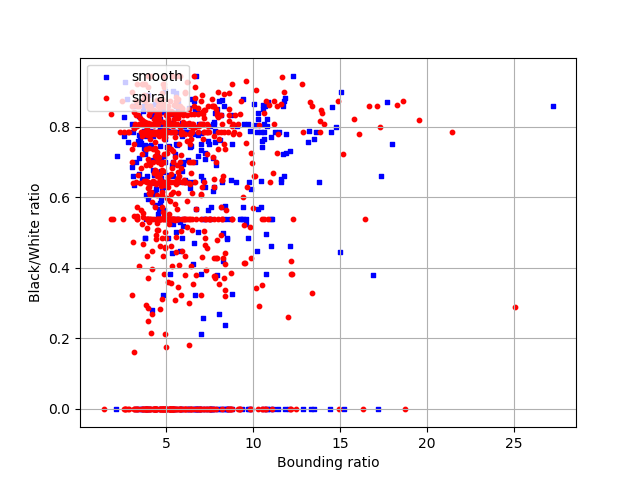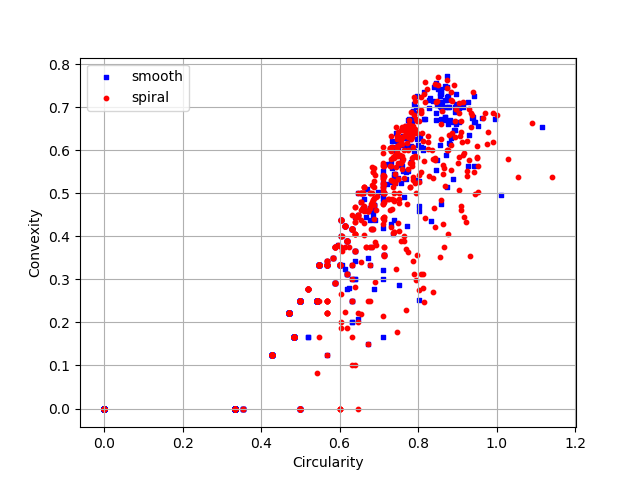

### Question 4

<i><b>À la suite de votre implémentation de l’arbre de décision, expliquer pour quelles raisons
votre arbre de décision donne un tel score de précision. Qu’a fait la variable max_depth
sur les performances de classification?</b></i>

Ce qui fait la force d'un arbre de décision c'est bien sûr, le caractère unique des variables selon la situation. Donc, les raisons qui font en sorte que l'arbre de décision à un tel score de précision sont: Une bonne analyse préliminaire du problème proposé, une lecture attentive des documents fournis et, sans oublier, le pouvoir discriminant des primitives sélectionnées.

La variable max_depth permet de limiter le nombre de décision effectué par l’arbre. Par contre, selon les tests effectués, elle a peu d’effet sur les performances de classification. Le tableau suivant montre les taux de succès pour les différentes valeurs de max_depth. 

<table>
    <tr>
        <th>Valeur de max_depth</th>
        <th>Taux de succès</th>
    </tr>    
    <tr>
        <td>3</td>
        <td>49.05 %</td>
    </tr>
    <tr>
        <td>5</td>
        <td>50.01 %</td>
    </tr>
    <tr>
        <td>8</td>
        <td>56.45 %</td>
    </tr>
    <tr>
        <td>10</td>
        <td>56.45 %</td>
    </tr>
</table> 

### Question 5

<i><b>Quelle autre primitive aurait également pu être ajoutée afin d’améliorer le pouvoir
discriminant ou la performance de régression des probabilités?</b></i>

D’autres primitives auraient pu améliorer le pourcentage de réussite. Par exemple, la forme de l’angle de l'ellipse peut donner une autre information associée à la forme de la figure qui est différente de la circularité. Dans le même ordre d’idée, le ratio de la hauteur et largeur de l'ellipse peut donner un meilleur ratio que la convexité.

Étant donné que les primitives utilisées sont basées sur la forme, il aurait été possible d’ajouter des primitives basées sur les pixels. Le document utilisé discute différentes primitives qui sont basées sur les pixels. Par exemple, la valeur maximale des couleurs rouges et bleues dans l’image ou bien le ratio de l’intensité des couleurs bleues et rouges.


### Conclusion

En conclusion, la lecture du document produit par Devendra Singh Dhami a beaucoup aidé à faire le laboratoire. Plusieurs primitives sont sélectionnées à l’aide à sa recherche. Pour résoudre le problème les primitives de circularité, convexité, le ratio de noir et blanc et le facteur de remplissage du rectangle de contour sont choisis. Enfin, un arbre de décision est construit pour classifier les nouveaux résultats. La méthode de test est de diviser les données en 70% pour entraîner et 30% pour tester.

Pendant ce laboratoire, les premières primitives choisies n’étaient pas très parlantes. Par conséquent, il était plus difficile de prendre une bonne décision qui est problématique. Ainsi, d’autres primitives sont ajoutées afin d’améliorer la prise de décision. Malgré les efforts ajoutés, les résultats ne sont pas optimums. Le meilleur résultat obtenu est de 56.45% avec une profondeur de l’arbre de 10.

Des améliorations peuvent facilement être ajoutées. Les primitives sont basées sur la forme de la galaxie. D’autres primitives basées sur les pixels peuvent être utilisées. Par exemple, les couleurs des pixels et des ratios associés à ceux-ci peuvent ajouter d’autres informations très utiles pour prendre une décision. L’association des primitives basées sur la forme et des primitives basées sur les pixels semble être la meilleure combinaison pour avoir un très grand pourcentage de réussite.

### Bibliographie

<b>Site web:</b>
- https://docs.opencv.org/3.4.2/dd/d49/tutorial_py_contour_features.html
- http://scikit-learn.org/stable/modules/tree.html
- https://www.anaconda.com/
- https://pythonprogramming.net/thresholding-image-analysis-python-opencv-tutorial/
- 
    
<b>Documentation:</b>
- Morphological classification of galaxies into spirals and non-spirals.pdf
- Galaxy Morphology Classification.pdf
- Anaconda Cheatsheet.pdf